In [1]:
import numpy as np
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

In [4]:
import os
import random

In [2]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

<ErrorbarContainer object of 3 artists>

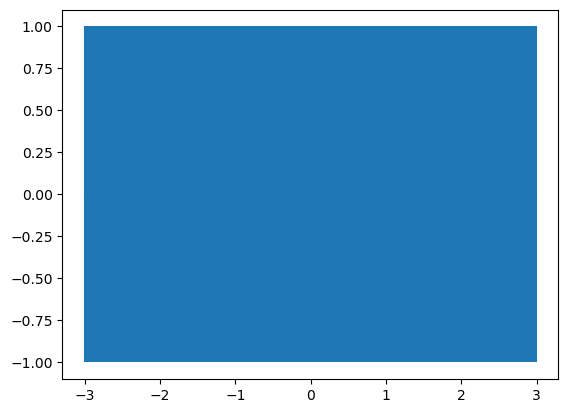

In [12]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import matplotlib.pylab as plt
theta = [1, 10]
σ_theta = exponential_cov(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_theta, capsize=0)

In [11]:
σ_theta

1.0

In [308]:
import os
import random
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd
from scipy.linalg import cho_solve, cho_factor
import gpytorch
from datetime import datetime
import torch
from scipy.linalg import cholesky,solve_triangular
import random
from scipy.optimize import minimize

In [14]:
appl_data_df = pd.read_csv("APPL.csv")
appl_data_df.head()

,Date,Open,High,Low,Close,Volume
0,06/27/2024,214.69,215.74,212.35,214.10,"49,772,711"
1,06/26/2024,211.50,214.86,210.64,213.25,"66,213,195"
2,06/25/2024,209.15,211.38,208.61,209.07,"56,713,871"
3,06/24/2024,207.72,212.70,206.59,208.14,"80,727,008"
4,06/21/2024,210.39,211.89,207.11,207.49,"246,421,406"


In [15]:
# Convert the 'Date' column to datetime
appl_data_df['Date'] = pd.to_datetime(appl_data_df['Date'], format='%m/%d/%Y')

# Format the 'Date' column to 'yyyy-mm-dd'
appl_data_df['Date'] = appl_data_df['Date'].dt.strftime('%Y-%m-%d')

appl_data_df.head()

,Date,Open,High,Low,Close,Volume
0,2024-06-27,214.69,215.74,212.35,214.10,"49,772,711"
1,2024-06-26,211.50,214.86,210.64,213.25,"66,213,195"
2,2024-06-25,209.15,211.38,208.61,209.07,"56,713,871"
3,2024-06-24,207.72,212.70,206.59,208.14,"80,727,008"
4,2024-06-21,210.39,211.89,207.11,207.49,"246,421,406"


In [16]:
model_df = appl_data_df.copy()

In [17]:
model_df = model_df.sort_values(by='Date').reset_index(drop=True)

In [299]:
model_train = model_df[['Date','Close']].copy()
model_train_subset = model_train[(model_train['Date'] >= '2023-10-01') & (model_train['Date'] < '2024-03-02')]
model_train_subset_test = model_train[(model_train['Date'] >= '2024-03-02') & (model_train['Date'] <= '2024-03-14')]
model_train_subset['Date'] = pd.to_datetime(model_train_subset['Date'])
model_train_subset['Date_ordinal'] = model_train_subset['Date'].apply(lambda x: x.toordinal())
model_train_subset_test['Date'] = pd.to_datetime(model_train_subset_test['Date'])
model_train_subset_test['Date_ordinal'] = model_train_subset_test['Date'].apply(lambda x: x.toordinal()) 
model_train_subset_test.head(10)

C:\Users\aman1\AppData\Local\Temp\ipykernel_25120\3904797916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset['Date'] = pd.to_datetime(model_train_subset['Date'])
C:\Users\aman1\AppData\Local\Temp\ipykernel_25120\3904797916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset['Date_ordinal'] = model_train_subset['Date'].apply(lambda x: x.toordinal())
C:\Users\aman1\AppData\Local\Temp\ipykernel_25120\3904797916.py:6: SettingWithCopyWarning: 
A value is trying to be set

,Date,Close,Date_ordinal
172,2024-03-04,175.10,738949
173,2024-03-05,170.12,738950
174,2024-03-06,169.12,738951
175,2024-03-07,169.00,738952
176,2024-03-08,170.73,738953
177,2024-03-11,172.75,738956
178,2024-03-12,173.23,738957
179,2024-03-13,171.13,738958
180,2024-03-14,173.00,738959


In [300]:
model_train_final = model_train_subset.copy()
model_train_final_test = model_train_subset_test.copy()

mean = model_train_final['Date_ordinal'].mean()
std = model_train_final['Date_ordinal'].std()

model_train_final['Date_ordinal'] = (model_train_final['Date_ordinal'] - mean)/std
model_train_final_test['Date_ordinal'] = (model_train_final_test['Date_ordinal'] - mean)/std

X_train2 = model_train_final['Date_ordinal'].values
y_train2 = model_train_final['Close'].values

X_test2 = model_train_final_test['Date_ordinal'].values
y_test2 = model_train_final_test['Close'].values

In [301]:
# Define the RBF kernel function
def rbf_kernel2(x1, x2, length_scale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return variance * np.exp(-0.5 * sqdist / length_scale**2)

In [302]:
X_obs = X_train2
y_obs = y_train2

X_obs = X_obs.reshape(-1, 1)

prior = y_train2.mean()

optimized_length_scale = 0.25
optimized_variance = 25

noise = 1e-3
num_samples = 25

# Compute covariance matrices for predictions
K_obs = rbf_kernel2(X_obs, X_obs, optimized_length_scale, optimized_variance)
K_s = rbf_kernel2(X_obs, X_obs, optimized_length_scale, optimized_variance)
K_ss = rbf_kernel2(X_obs, X_obs, optimized_length_scale, optimized_variance)
K_obs_inv = np.linalg.inv(K_obs + noise * np.eye(len(X_obs)))

# Compute the mean and covariance of the posterior
mu_s = y_train2.mean() + np.dot(K_s, np.dot(K_obs_inv, (y_obs - y_train2.mean()) ))
cov_s = K_ss - np.dot(K_s, np.dot(K_obs_inv, K_s.T))
cov_s_actual = []
for i in range(len(cov_s[0])):
    cov_s_actual.append(cov_s[i,i])

# Sample from the posterior
L_post = cholesky(cov_s + noise * np.eye(len(X_obs)), lower=True)
f_post = mu_s.reshape(-1, 1) + np.dot(L_post, np.random.normal(size=(len(X_obs), num_samples)))

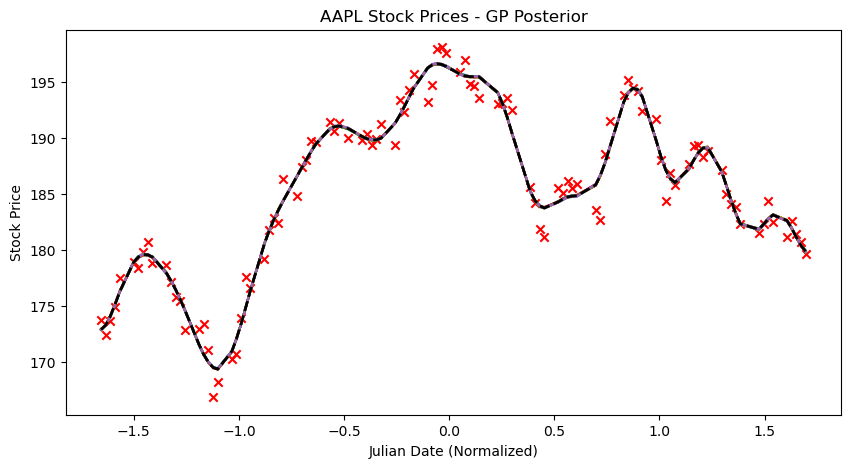

In [303]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot samples from the posterior
plt.figure(figsize=(10, 5))
plt.plot(X_train2, f_post, label="Posterior Samples")
plt.scatter(X_train2, y_obs, c='red', marker='x', label="Observed Data")
plt.plot(X_train2, mu_s, 'k--', lw=2, label="Posterior Mean")
plt.fill_between(X_train2.flatten(), 
                 mu_s.flatten() - 1.96 * np.sqrt(np.diag(cov_s)), 
                 mu_s.flatten() + 1.96 * np.sqrt(np.diag(cov_s)), 
                 alpha=0.2, label="95% Confidence Interval")
plt.title("AAPL Stock Prices - GP Posterior")
plt.xlabel("Julian Date (Normalized)")
plt.ylabel("Stock Price")
#plt.legend()
plt.show()

In [304]:
# Compute the covariance vector between the new date and observed dates
K_new = rbf_kernel2(X_test2.reshape(-1, 1), X_obs, optimized_length_scale, optimized_variance)
K_new_new = rbf_kernel2(X_test2.reshape(-1, 1), X_test2.reshape(-1, 1), optimized_length_scale, optimized_variance)

# Compute the mean and variance of the posterior at the new date
mu_new = np.dot(K_new, np.dot(K_obs_inv, y_obs))
cov_new = K_new_new - np.dot(K_new, np.dot(K_obs_inv, K_new.T))

# Compute the standard deviation
sigma_new = np.sqrt(np.diag(cov_new))

# Print the predicted means and standard deviations
for i in range(len(X_test2)):
    print(f"Predicted mean at new date {X_test2[i]}: {mu_new[i]}")
    print(f"Actual value at new date {X_test2[i]}: {y_test2[i]}")
    print(f"Predicted standard deviation at new date {X_test2[i]}: {sigma_new[i]}")

Predicted mean at new date 1.7619897431663254: 179.6488216154903
Actual value at new date 1.7619897431663254: 175.1
Predicted standard deviation at new date 1.7619897431663254: 0.15969778551745084
Predicted mean at new date 1.7841810497553154: 180.34980955971332
Actual value at new date 1.7841810497553154: 170.12
Predicted standard deviation at new date 1.7841810497553154: 0.24602996827867638
Predicted mean at new date 1.8063723563443055: 181.34806561505684
Actual value at new date 1.8063723563443055: 169.12
Predicted standard deviation at new date 1.8063723563443055: 0.35831325242635303
Predicted mean at new date 1.8285636629332955: 182.50383016132037
Actual value at new date 1.8285636629332955: 169.0
Predicted standard deviation at new date 1.8285636629332955: 0.4984943612409189
Predicted mean at new date 1.8507549695222856: 183.6254596844774
Actual value at new date 1.8507549695222856: 170.73
Predicted standard deviation at new date 1.8507549695222856: 0.6674358907298352
Predicted m

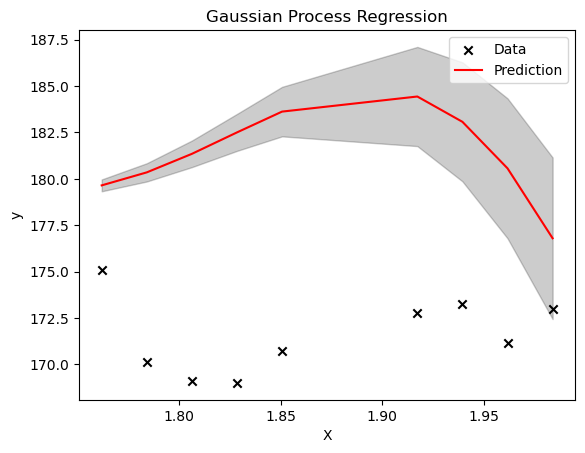

In [305]:
plt.figure()
plt.scatter(X_test2, y_test2, c='k', marker='x', label='Data')
plt.plot(X_test2, mu_new, c='r', label='Prediction')
plt.fill_between(X_test2.ravel(), mu_new - 2*sigma_new, mu_new + 2*sigma_new, alpha=0.2, color='k')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()

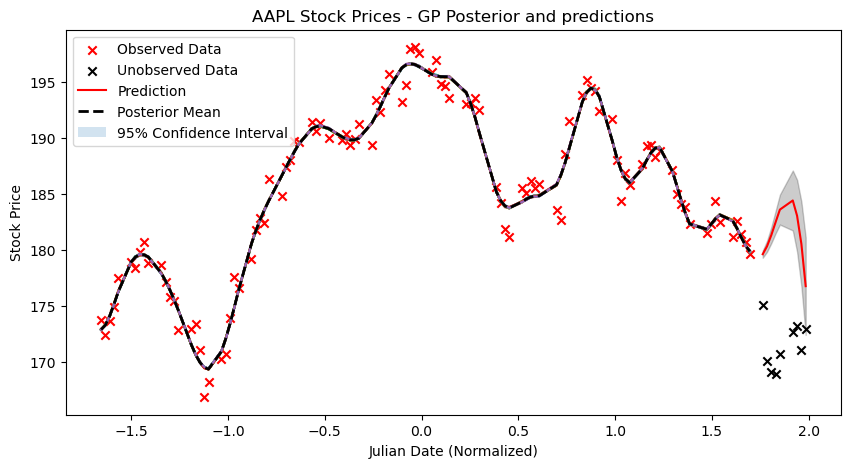

In [306]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot samples from the posterior
plt.figure(figsize=(10, 5))
plt.plot(X_train2, f_post)
plt.scatter(X_train2, y_obs, c='red', marker='x', label="Observed Data")
plt.scatter(X_test2, y_test2, c='k', marker='x', label='Unobserved Data')
plt.plot(X_test2, mu_new, c='r', label='Prediction')
plt.plot(X_train2, mu_s, 'k--', lw=2, label="Posterior Mean")
plt.fill_between(X_train2.flatten(), 
                 mu_s.flatten() - 1.96 * np.sqrt(np.diag(cov_s)), 
                 mu_s.flatten() + 1.96 * np.sqrt(np.diag(cov_s)), 
                 alpha=0.2, label="95% Confidence Interval")
plt.fill_between(X_test2.ravel(), mu_new - 2*sigma_new, mu_new + 2*sigma_new, alpha=0.2, color='k')
plt.title("AAPL Stock Prices - GP Posterior and predictions")
plt.xlabel("Julian Date (Normalized)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [309]:
# Define the composite kernel
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

# Create the GaussianProcessRegressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

In [316]:
gpr.fit(X_train2.reshape(-1, 1), y_train2)
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
n_restarts_optimizer=0, normalize_y=False,
optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1))

In [318]:
gpr.kernel_

185**2 + Matern(length_scale=0.485, nu=1.5) + WhiteKernel(noise_level=29)

In [320]:
y_pred, sigma = gpr.predict(X_test2.reshape(-1, 1), return_std=True)

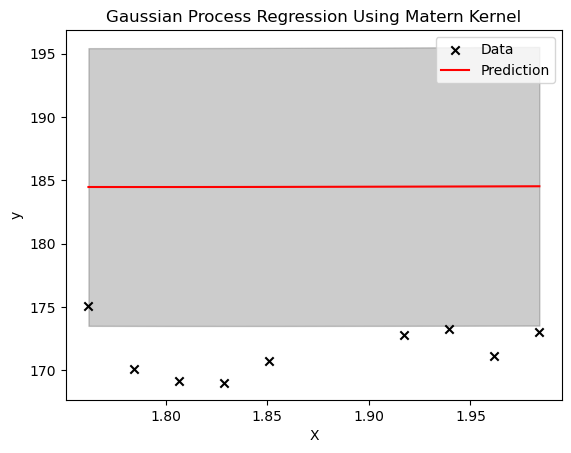

In [337]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure()
plt.scatter(X_test2, y_test2, c='k', marker='x', label='Data')
plt.plot(X_test2, y_pred, c='r', label='Prediction')
plt.fill_between(X_test2.ravel(), y_pred - 2*sigma, y_pred + 2*sigma, alpha=0.2, color='k')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gaussian Process Regression Using Matern Kernel')
plt.legend()
plt.show()

In [322]:
y_train_pred, y_train_pred_std = gpr.predict(X_train2.reshape(-1, 1), return_std=True)

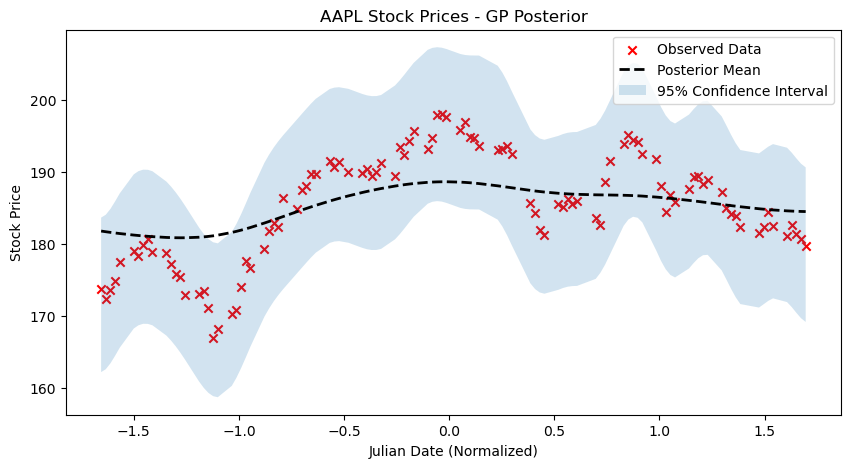

In [326]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot samples from the posterior
plt.figure(figsize=(10, 5))
#plt.plot(X_train2, f_post, label="Posterior Samples")
plt.scatter(X_train2, y_train2, c='red', marker='x', label="Observed Data")
plt.plot(X_train2, y_train_pred, 'k--', lw=2, label="Posterior Mean")
plt.fill_between(X_train2.flatten(), 
                 mu_s.flatten() - 1.96 * y_train_pred_std, 
                 mu_s.flatten() + 1.96 * y_train_pred_std, 
                 alpha=0.2, label="95% Confidence Interval")
plt.title("AAPL Stock Prices - GP Posterior")
plt.xlabel("Julian Date (Normalized)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

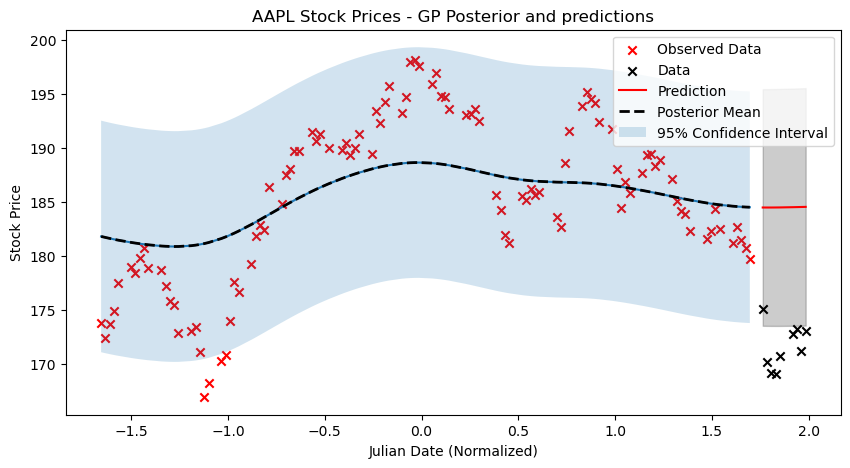

In [338]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot samples from the posterior
plt.figure(figsize=(10, 5))
plt.plot(X_train2, y_train_pred)
plt.scatter(X_train2, y_train2, c='red', marker='x', label="Observed Data")
plt.scatter(X_test2, y_test2, c='k', marker='x', label='Data')
plt.plot(X_test2, y_pred, c='r', label='Prediction')
plt.plot(X_train2, y_train_pred, 'k--', lw=2, label="Posterior Mean")
plt.fill_between(X_train2.flatten(), 
                 y_train_pred.flatten() - 1.96 * y_train_pred_std, 
                 y_train_pred.flatten() + 1.96 * y_train_pred_std, 
                 alpha=0.2, label="95% Confidence Interval")
plt.fill_between(X_test2.ravel(), y_pred - 2*sigma, y_pred + 2*sigma, alpha=0.2, color='k')
plt.title("AAPL Stock Prices - GP Posterior and predictions")
plt.xlabel("Julian Date (Normalized)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [440]:
# Define the composite kernel with specified hyperparameters
constant_value2 = 0.1
length_scale2 = 0.5
noise_level2 = 0.01
kernel2 = ConstantKernel(constant_value2) + Matern(length_scale=length_scale2, nu=1.5) + WhiteKernel(noise_level=noise_level2)
kernel3 = ConstantKernel(constant_value2) + RBF(length_scale=0.5) +  WhiteKernel(noise_level=noise_level2)
kernel4 = Matern(length_scale=length_scale2, nu=1.5) + ConstantKernel(constant_value2)

In [441]:
gpr2 = GaussianProcessRegressor(kernel=kernel4, n_restarts_optimizer=10)

In [442]:
gpr2.fit(X_train2.reshape(-1, 1), y_train2)

GaussianProcessRegressor(kernel=Matern(length_scale=0.5, nu=1.5) + 0.316**2,
                         n_restarts_optimizer=10)

In [443]:
y_pred2, sigma2 = gpr2.predict(X_test2.reshape(-1, 1), return_std=True)

In [444]:
y_train_pred2, y_train_pred_std2 = gpr2.predict(X_train2.reshape(-1, 1), return_std=True)

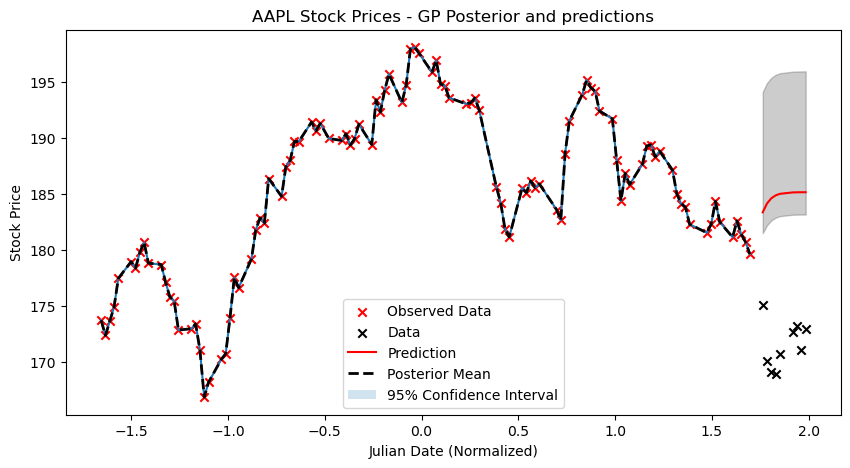

In [445]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot samples from the posterior
plt.figure(figsize=(10, 5))
plt.plot(X_train2, y_train_pred2)
plt.scatter(X_train2, y_train2, c='red', marker='x', label="Observed Data")
plt.scatter(X_test2, y_test2, c='k', marker='x', label='Data')
plt.plot(X_test2, y_pred2, c='r', label='Prediction')
plt.plot(X_train2, y_train_pred2, 'k--', lw=2, label="Posterior Mean")
plt.fill_between(X_train2.flatten(), 
                 y_train_pred2.flatten() - 1.96 * y_train_pred_std2, 
                 y_train_pred2.flatten() + 1.96 * y_train_pred_std2, 
                 alpha=0.2, label="95% Confidence Interval")
plt.fill_between(X_test2.ravel(), y_pred2 - 1.96*sigma2, y_pred2 + 1.96*sigma, alpha=0.2, color='k')
plt.title("AAPL Stock Prices - GP Posterior and predictions")
plt.xlabel("Julian Date (Normalized)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [384]:
y_train_pred2

array([181.78812629, 181.69407294, 181.60474049, 181.52047038,
       181.44124994, 181.23122337, 181.16988161, 181.11290727,
       181.06039503, 181.01254747, 180.9011898 , 180.87702396,
       180.86085522, 180.85366166, 180.85635744, 180.93145497,
       180.98174918, 181.04633304, 181.12595511, 181.22099833,
       181.59522371, 181.74820381, 181.91450283, 182.09308962,
       182.28266211, 182.90289678, 183.12222784, 183.34571412,
       183.57208435, 183.80011413, 184.48301567, 184.7069652 ,
       184.92749378, 185.14379388, 185.35522686, 185.95676592,
       186.14536153, 186.32761189, 186.6733459 , 187.1470696 ,
       187.29312927, 187.43309171, 187.56685884, 187.69430472,
       188.03713922, 188.13720745, 188.22928379, 188.31285423,
       188.38748094, 188.55528766, 188.59146147, 188.61692654,
       188.63132645, 188.63462405, 188.58184149, 188.54459685,
       188.49803443, 188.44278317, 188.3796768 , 188.06900061,
       187.98105288, 187.89044287, 187.79812196, 187.43

In [385]:
y_train_pred

array([181.7881157 , 181.69406355, 181.60473225, 181.52046322,
       181.44124382, 181.23122032, 181.16987962, 181.11290639,
       181.0603953 , 181.01254894, 180.90119519, 180.8770307 ,
       180.8608633 , 180.85367106, 180.85636809, 180.93146879,
       180.98176377, 181.04634821, 181.12597063, 181.22101395,
       181.59523827, 181.74821759, 181.91451561, 182.09310121,
       182.28267237, 182.90290243, 183.12223187, 183.3457165 ,
       183.57208511, 183.80011331, 184.48301051, 184.70695876,
       184.92748619, 185.14378525, 185.35521733, 185.95675435,
       186.14534949, 186.32759948, 186.67333296, 187.14705617,
       187.2931157 , 187.43307799, 187.56684498, 187.69429071,
       188.03712472, 188.13719278, 188.22926898, 188.31283931,
       188.38746596, 188.55527289, 188.59144693, 188.61691234,
       188.63131273, 188.63461095, 188.58183101, 188.54458748,
       188.4980263 , 188.44277638, 188.37967143, 188.06900145,
       187.98105531, 187.8904469 , 187.79812757, 187.43

In [446]:
# Define the composite kernel
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2)

# Create the GaussianProcessRegressor
gpr3 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

In [447]:
gpr3.fit(X_train2.reshape(-1, 1), y_train2)
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
kernel=1**2 + Matern(length_scale=2, nu=1.5),
n_restarts_optimizer=0, normalize_y=False,
optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(kernel=1**2 + Matern(length_scale=2, nu=1.5))

In [451]:
gpr3.kernel_

185**2 + Matern(length_scale=0.0484, nu=1.5)

In [452]:
y_pred, sigma = gpr3.predict(X_test2.reshape(-1, 1), return_std=True)

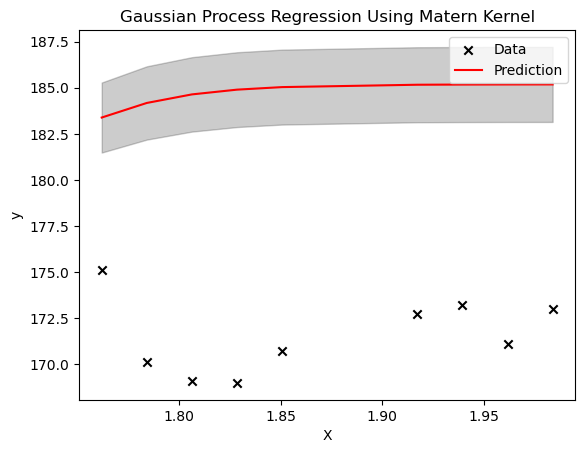

In [453]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure()
plt.scatter(X_test2, y_test2, c='k', marker='x', label='Data')
plt.plot(X_test2, y_pred, c='r', label='Prediction')
plt.fill_between(X_test2.ravel(), y_pred - 2*sigma, y_pred + 2*sigma, alpha=0.2, color='k')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gaussian Process Regression Using Matern Kernel')
plt.legend()
plt.show()

In [457]:
y_train_pred, y_train_pred_std = gpr3.predict(X_train2.reshape(-1, 1), return_std=True)

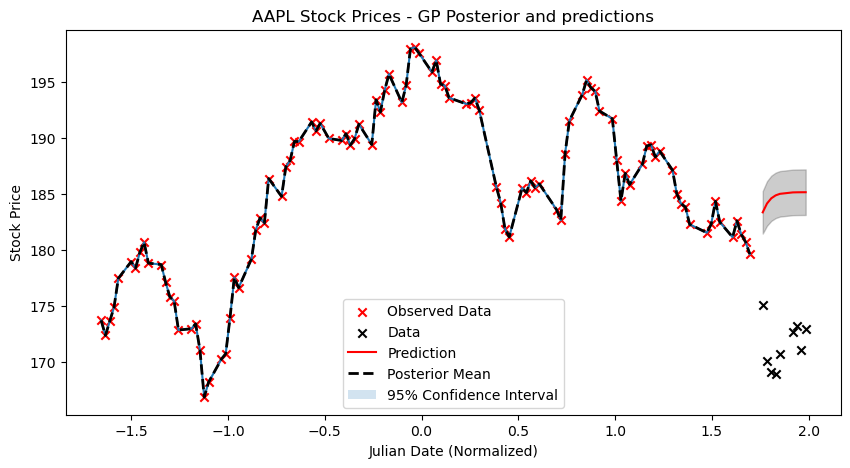

In [458]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot samples from the posterior
plt.figure(figsize=(10, 5))
plt.plot(X_train2, y_train_pred)
plt.scatter(X_train2, y_train2, c='red', marker='x', label="Observed Data")
plt.scatter(X_test2, y_test2, c='k', marker='x', label='Data')
plt.plot(X_test2, y_pred, c='r', label='Prediction')
plt.plot(X_train2, y_train_pred, 'k--', lw=2, label="Posterior Mean")
plt.fill_between(X_train2.flatten(), 
                 y_train_pred.flatten() - 1.96 * y_train_pred_std, 
                 y_train_pred.flatten() + 1.96 * y_train_pred_std, 
                 alpha=0.2, label="95% Confidence Interval")
plt.fill_between(X_test2.ravel(), y_pred - 2*sigma, y_pred + 2*sigma, alpha=0.2, color='k')
plt.title("AAPL Stock Prices - GP Posterior and predictions")
plt.xlabel("Julian Date (Normalized)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()